In [2]:
using CairoMakie
using Statistics
using Distributions
using Random

function lorenz96(u, F)
    len = length(u)
    du = zeros(Float64, len)
    for i = 1:len
        du[i] = (u[mod(i + 1 - 1, len) + 1] .- u[mod(i - 2 - 1, len) + 1]) .* u[mod(i - 1 - 1, len) + 1] .- u[mod(i - 1, len) + 1] .+ F
    end
    return du
end;

function rk4_step(u, dt, F)
    k1 = lorenz96(u, F)
    k2 = lorenz96(u .+ dt * k1/2.0, F)
    k3 = lorenz96(u .+ dt * k2/2.0, F)
    k4 = lorenz96(u .+ dt * k3, F)
    u_next = u .+ (dt/6.0) .* (k1 .+ 2.0 .*k2 .+ 2.0 .*k3 .+ k4)
    return u_next
end;

function solver(u0, dt, tstep, F; spin_up_time=0, add_noise=false, std=0.1, only_step_mode=false)
    if only_step_mode
        try tstep != 1 catch
            error("tstep must be 1")
        end
        return rk4_step(u0, dt, F)
    else
        dus = zeros(Float64, length(u0), tstep)

        tmp_du = u0
        for t in 1:spin_up_time
            tmp_du = rk4_step(tmp_du, dt, F)
        end

        dus[:, 1] = tmp_du

        for t in 2:tstep
            if t==add_noise
                dus[:, t] = rk4_step(dus[:, t-1] + std * rand(Normal(0, 1), length(u0)), dt, F)
            else
                dus[:, t] = rk4_step(dus[:, t-1], dt, F)
            end

        end
        return dus
    end
end;


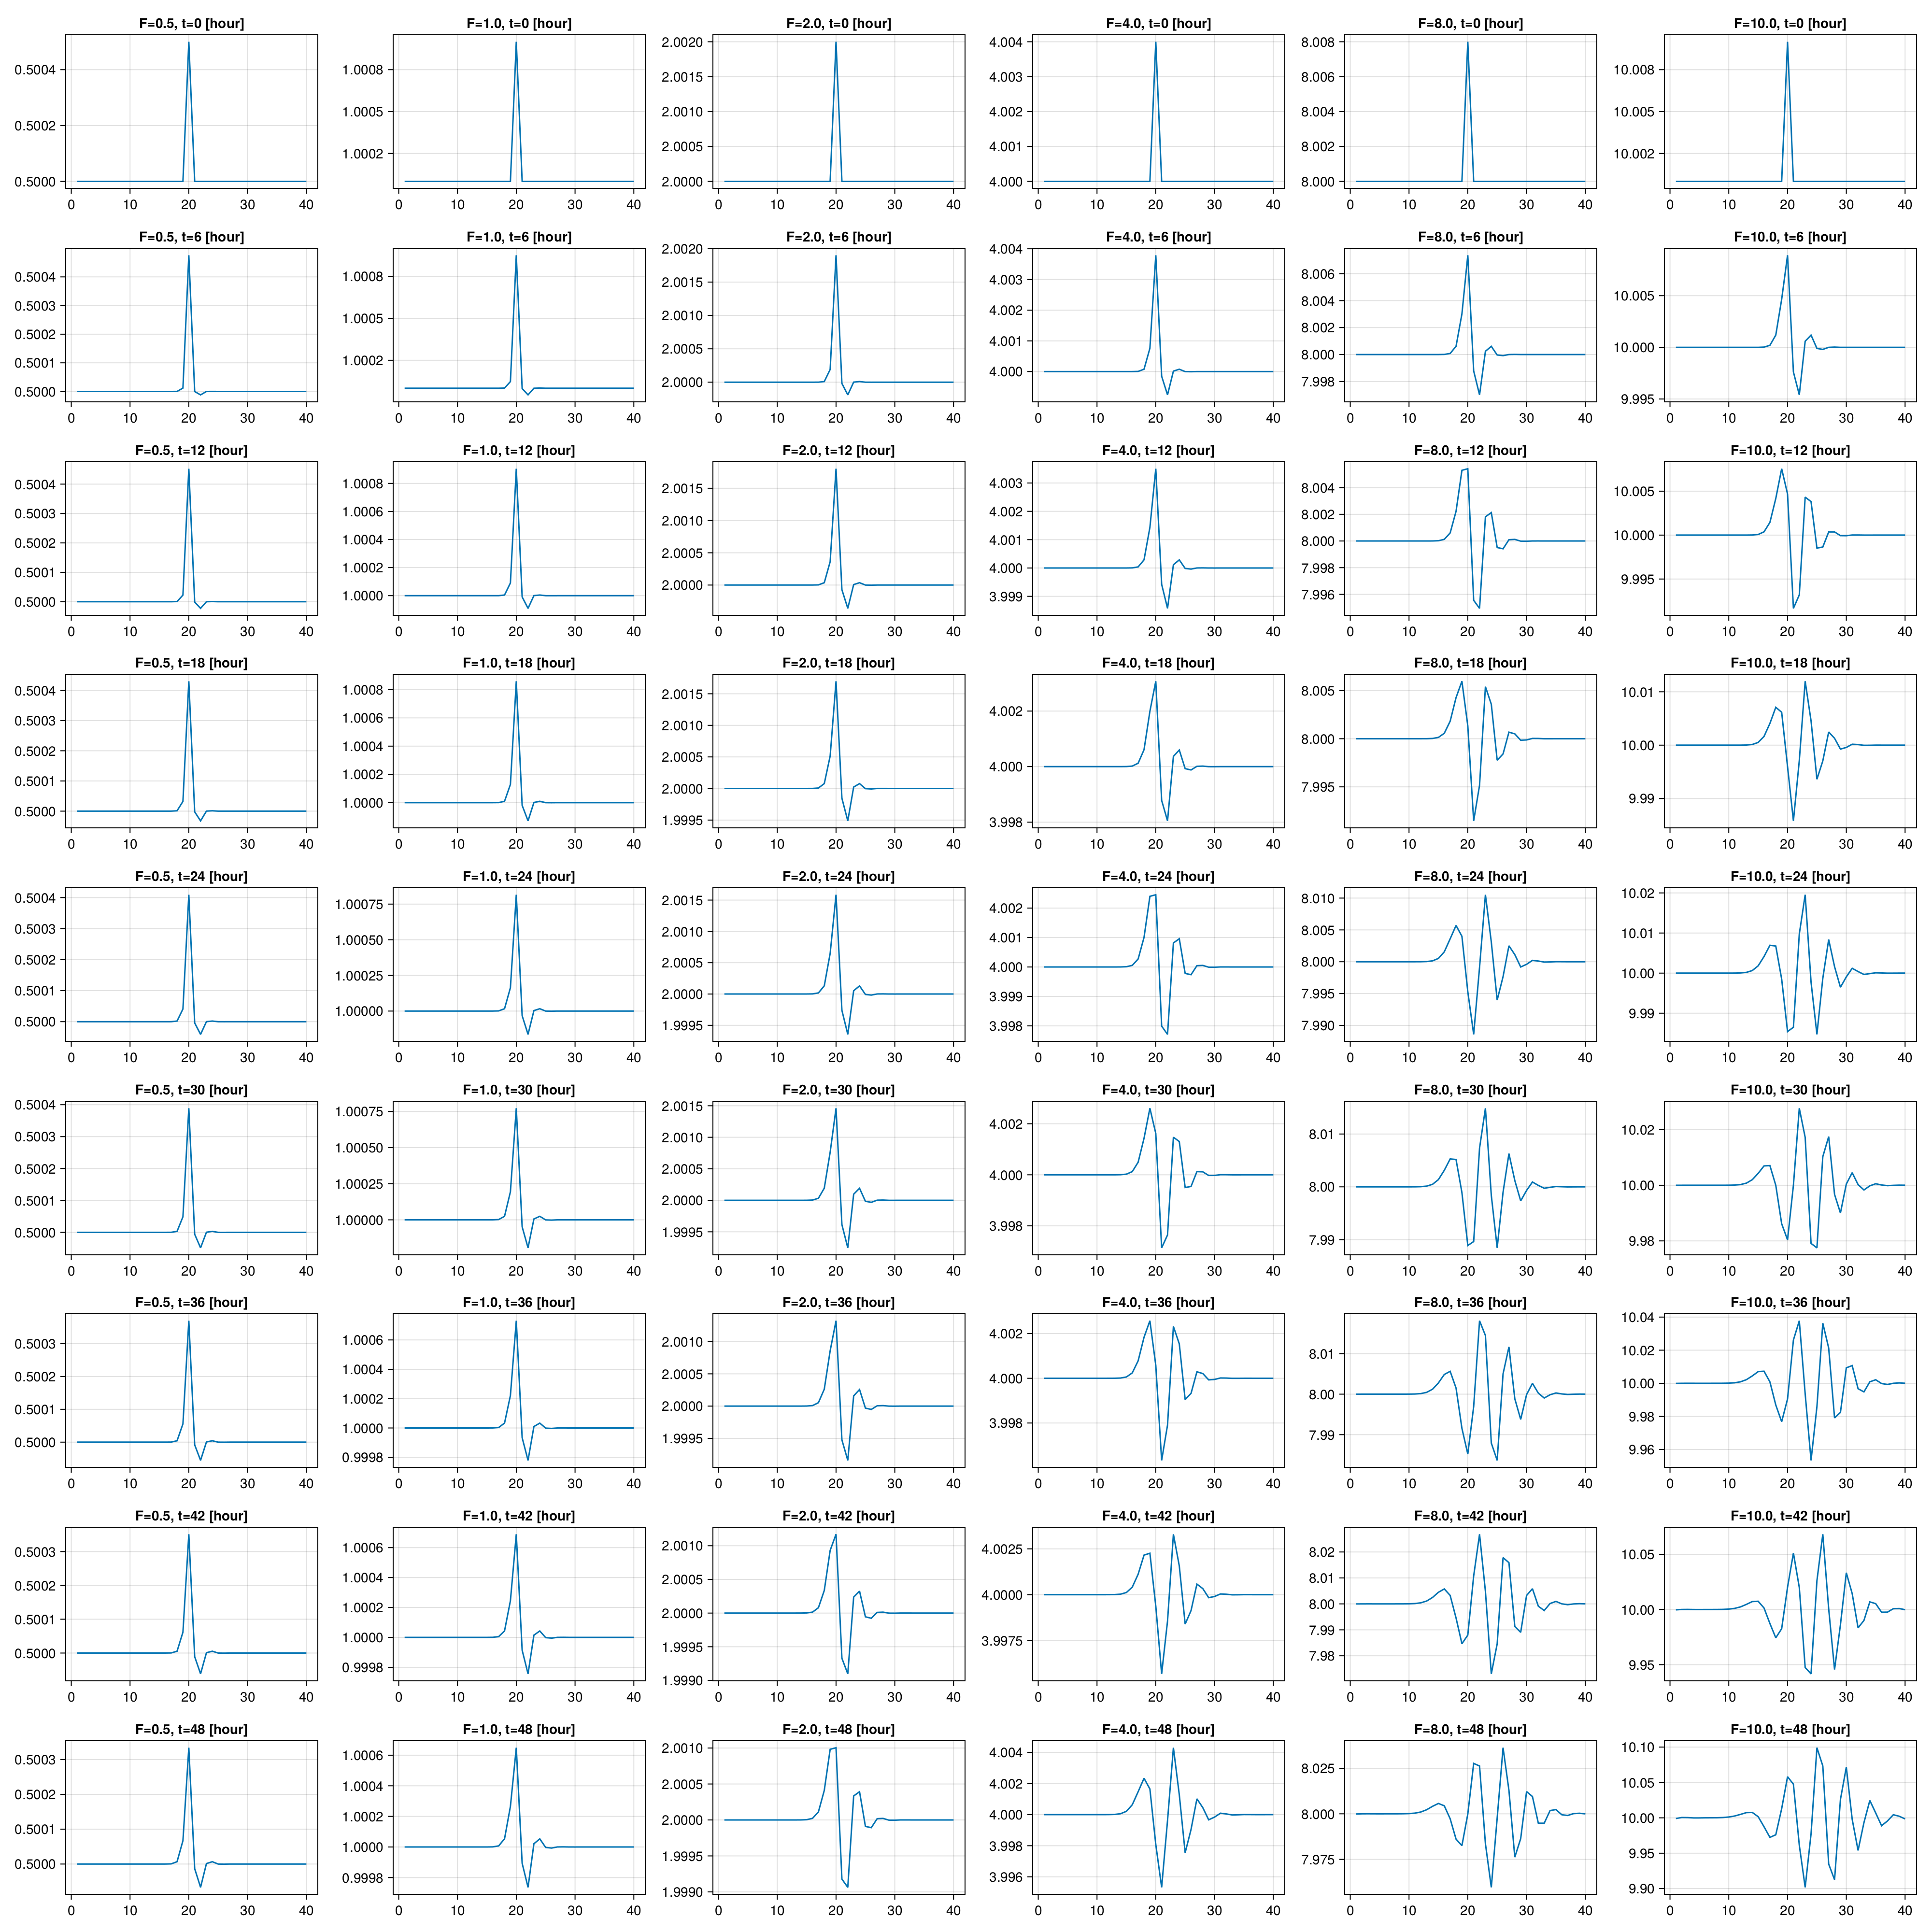

CairoMakie.Screen{IMAGE}


In [5]:
using CairoMakie

n_site = 40
# u = append!(ones(Float64, 16), [1.0001], ones(Float64, 17))
tstep = 100
dt = 0.05 # eq 6 hours

fig = Figure(size=(2000, 2000))
# fig = Figure(size=(800, 2200))

for (idx_f, f) in enumerate([0.5, 1, 2, 4, 8, 10])
    u = append!(ones(Float64, Integer((n_site/2)-1)) * f, [f * 1.001], ones(Float64, Integer(n_site/2)) * f)
    sol = solver(u, dt, tstep, f)
    # xticks=range(0, tstep, 9),
    # xminorticks=range(0, tstep, 25), xminorticksvisible=true)
    a = []
    for (idx, t) = enumerate(1:1:9)
        lt = t - 1
        lt *= 6
        ax = fig[idx, idx_f] = Axis(fig, title="F=$f, t=$lt [hour]")

        lines!(ax, range(1, n_site), sol[:, t], labels="$lt [hour]")
    end

end

display(fig)

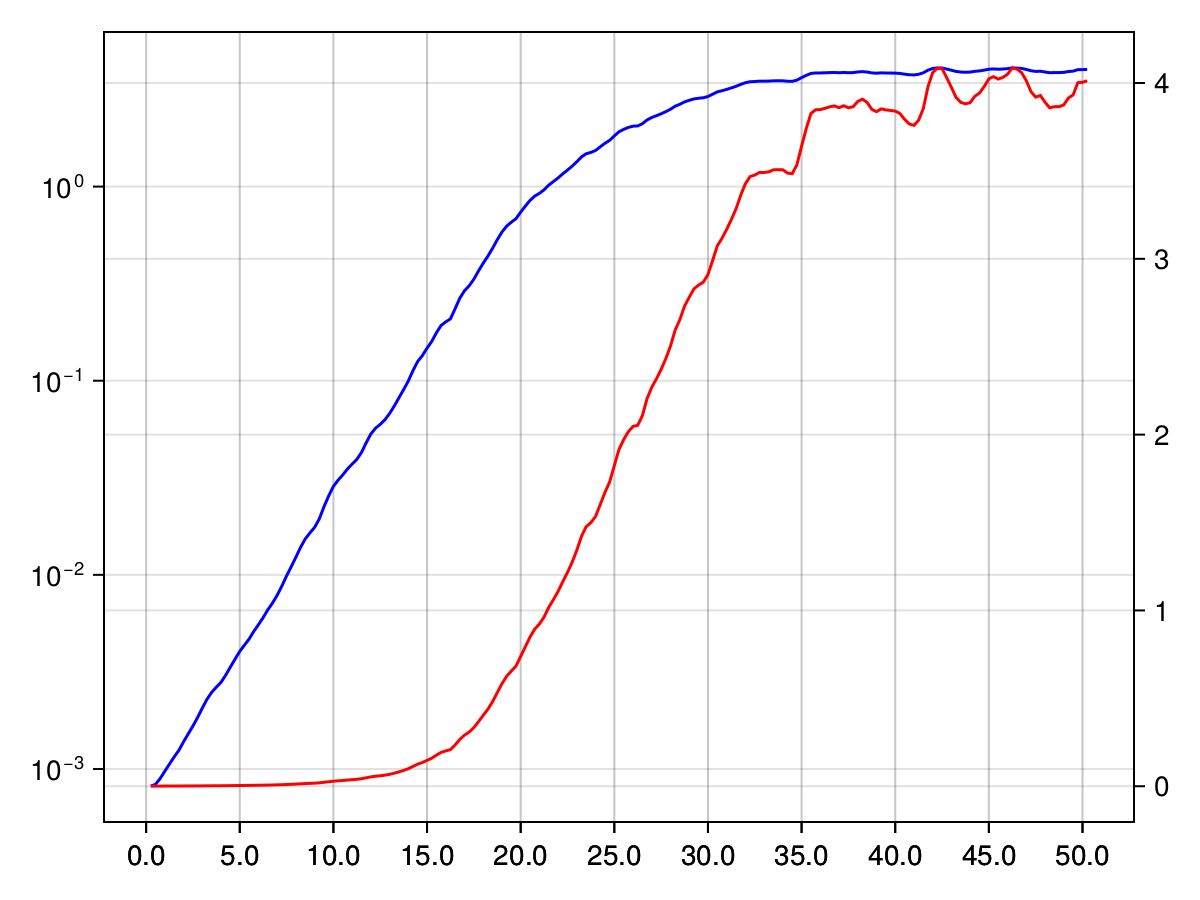

200


CairoMakie.Screen{IMAGE}


In [6]:
Random.seed!(1234)

step_as_time = 6 # 6 hours

n_site = 36
dt = 0.05 # eq 6 hours
force = 8
try_number = 1000
err_add = 0.001

# step_per_day = Integer(24 / step_as_time)
u = randn(n_site)
tstep = Integer(50*24/step_as_time) # 50 days
println(tstep)


spin_up_time = Integer(3 * 365 * 24 / step_as_time) # 3年間

errs = zeros(try_number, tstep + 1)

for s in range(1, try_number)
    # u = append!(ones(Float64, Integer((n_site/2)-1)) * force, [force * 1.001], ones(Float64, Integer(n_site/2)) * force)
    sol = solver(u, dt, s + tstep, force; spin_up_time=spin_up_time, add_noise=s, std=err_add)
    sol_ctl = solver(u, dt, s + tstep, force; spin_up_time=spin_up_time)
    err = mean.(sqrt.((sol[1, s: s + tstep] .- sol_ctl[1, s: s + tstep]).^2))
    errs[s, :] = err
end

errs = mean(errs, dims=1)

foraxishour = 20
fig = Figure()
ax1 = fig[1, 1] = Axis(fig, xticks=((0:foraxishour:tstep), string.((0:foraxishour:tstep)*step_as_time/24)); yscale=log10) # 6は一日あたりのステップ数
ax2 = fig[1, 1] = Axis(fig, xticks=((0:foraxishour:tstep), string.((0:foraxishour:tstep)*step_as_time/24)); yaxisposition = :right)
# hidespines!(ax2)
# hidexdecorations!(ax2)

lines!(ax1, range(1, tstep+1), errs[1, :], color = :blue)
lines!(ax2, range(1, tstep+1), errs[1, :], color = :red)
# lines!(sol[1, :])
# lines!(sol_ctl[1, :], labels="ctl")
display(fig)


## Making nature run and observation

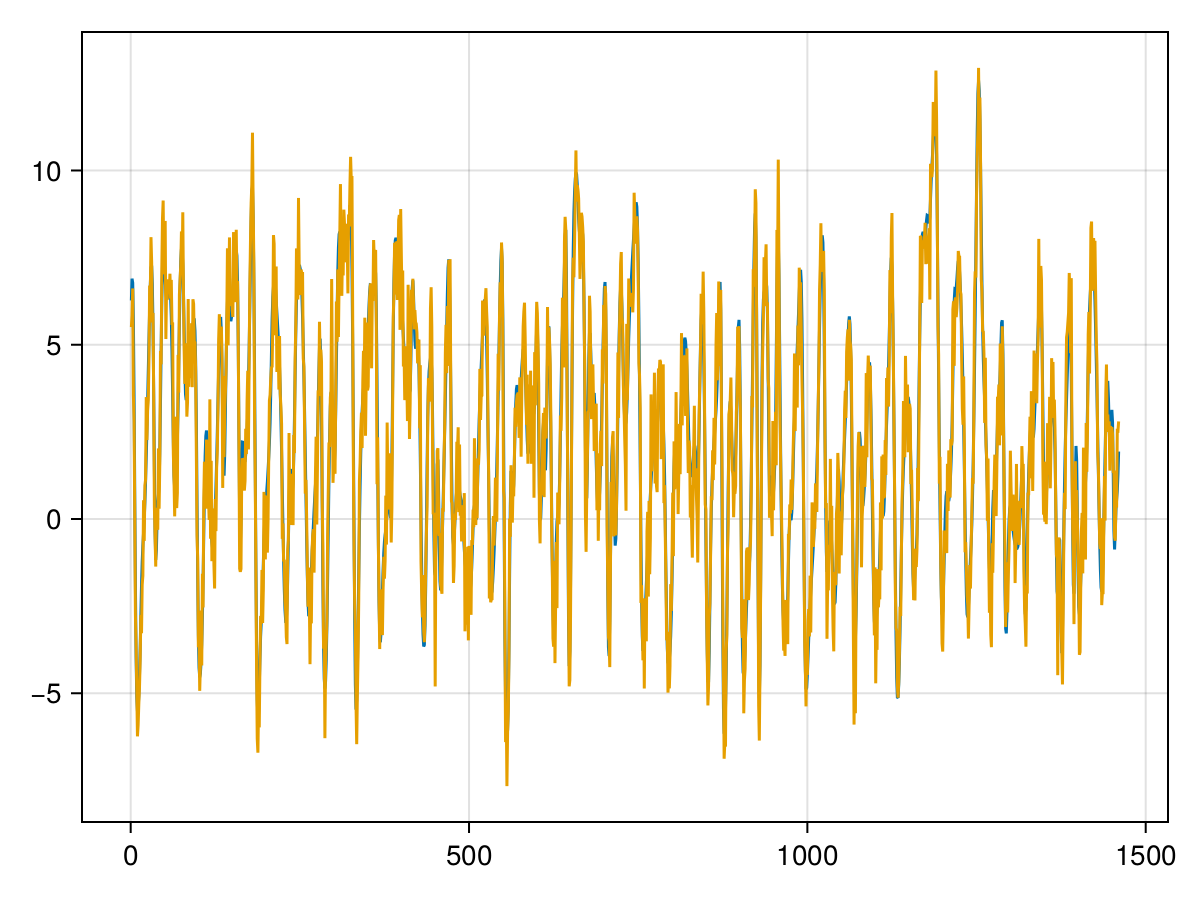

CairoMakie.Screen{IMAGE}


In [7]:
Random.seed!(1234)

step_as_time = 6 # 6 hours
n_site = 40
dt = 0.05 # eq 6 hours
force = 8
u = randn(n_site) .+ force
tstep = Integer(365 * 24 / step_as_time) # 1年間
spin_up_time = 365 * 24 / step_as_time # 1年間

sol_true = solver(u, dt, tstep, force; spin_up_time=spin_up_time)
sol_obs = sol_true + rand(Normal(0, 1), size(sol_true))

fig = Figure()
ax = fig[1, 1] = Axis(fig)
lines!(sol_true[1, :])
lines!(sol_obs[1, :])
display(fig)

## Kalman Filter implementation

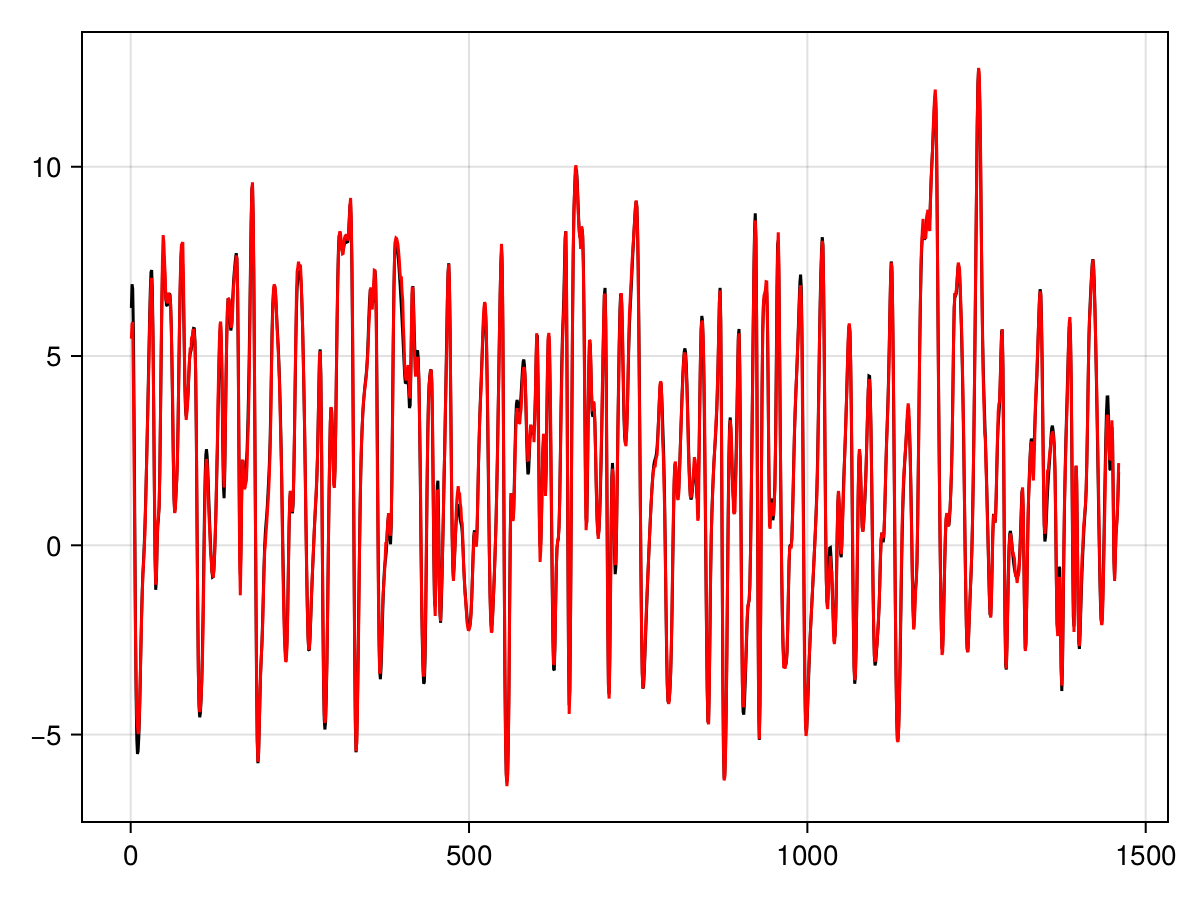

CairoMakie.Screen{IMAGE}


In [8]:
using LinearAlgebra

function rmse(y, y_hat; dims=NaN)
    return sqrt.(mean((y .- y_hat).^2, dims=1))
end

function kalman_filter(n_site, m_site, force, dt, time_step, observation; inf_parameter=0.1, delta=1.0e-5)
    # Defining initial value
    u_obs = copy(observation)
    u0 = randn(n_site) .+ force

    H = Matrix(1.0I, n_site, n_site)
    R = Matrix(1.0I, m_site, m_site)

    # for M Matrix ====================
    In = Matrix(1.0I, n_site, n_site)
    # =================================

    u0 = solver(u0, dt, time_step, force)
    ua = u0[:, end]
    Pa = 10.0 .* In

    # Store vector
    uas = zeros(n_site, time_step)
    pa_trs = zeros(time_step)

    # T loop
    for i in range(1, time_step)
        ub = solver(ua, dt, 1, force; only_step_mode=true)
        M_Ja = zeros(n_site, n_site)
        for j in 1:m_site
            M_Ja[:, j] = (solver(ua + delta * In[:,j], dt, 1, force; only_step_mode=true) -
                                solver(ua, dt, 1, force; only_step_mode=true)) / delta
        end
        Pb = (1. + inf_parameter) * M_Ja * Pa * M_Ja'
        # Analysis ===================================
        # println(size(inv(H * Pb * H' + R)))
        K = Pb * H' * inv(H * Pb * H' + R)
        ua = ub + K * (u_obs[:, i] - H * ub)
        Pa = (I - K * H) * Pb

        # Store result ===============================
        uas[:, i] = copy(ua)
        pa_trs[i] = sqrt(tr(Pa)/n_site)

    end
    return uas, pa_trs
end

inf_parameter = .1
delta = 1.0e-5

time_step = tstep
n_site = 40
m_site = 40
force = 8.0
dt = 0.05 # eq 6 hours

u_true = copy(sol_true)

(uas, pas) = kalman_filter(n_site, m_site, force, dt, time_step, sol_obs; inf_parameter=inf_parameter, delta=delta)

fig = Figure(figsize=(800, 2000), )
ax = fig[1, 1] = Axis(fig)
# lines!(ax, range(1, tstep), u_true[1, :])
lin1 = lines!(ax, range(1, tstep), u_true[1, :], color=:black, labels="Observation")
lin2 = lines!(ax, range(1, tstep), uas[1, :], color=:red, labels="Analysis")
display(fig)


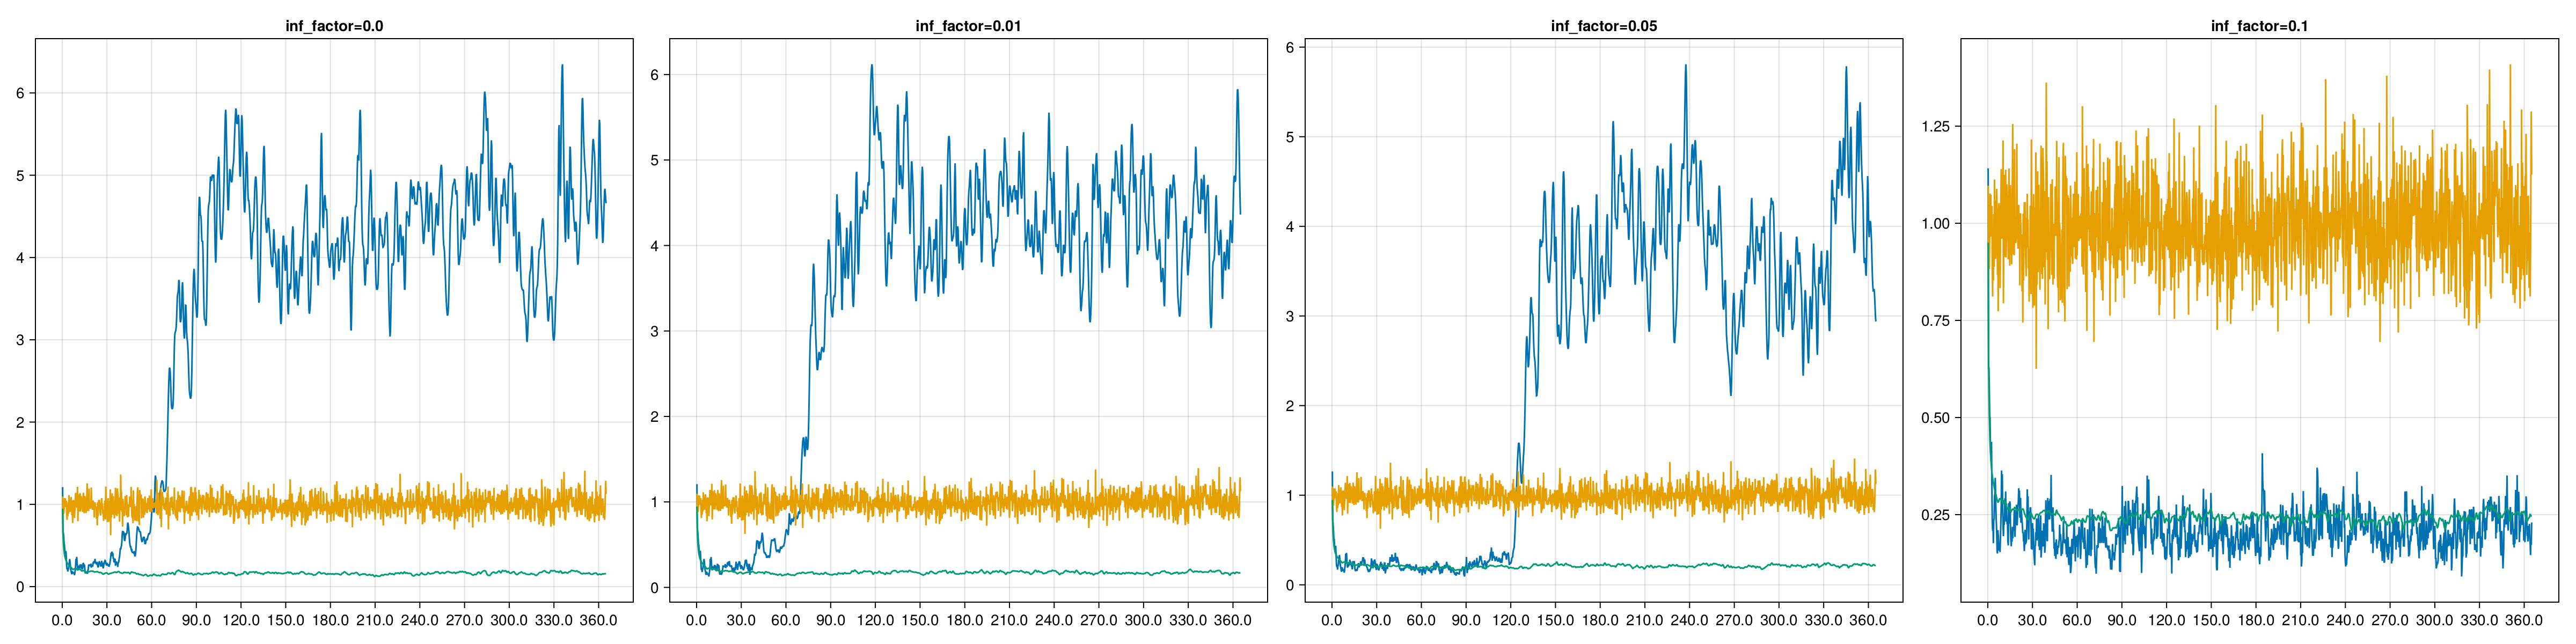

CairoMakie.Screen{IMAGE}


In [9]:
fig = Figure(size=(2400, 600))

for (i, inf_factor) in enumerate([0, 0.01, 0.05, 0.1])
    (uas, pas) = kalman_filter(n_site, m_site, force, dt, time_step, sol_obs; inf_parameter=inf_factor, delta=delta)

    rmse_cal = rmse(u_true, uas, dims=1)
    rmse_obs = rmse(u_true, sol_obs, dims=1)

    ax = fig[1, i] = Axis(fig, xticks=((0:120:tstep), string.((0:120:tstep)*step_as_time/24)),
                          title="inf_factor=$inf_factor")
    lines!(ax, range(1, tstep), rmse_cal[1, :])
    lines!(ax, range(1, tstep), rmse_obs[1, :])
    lines!(ax, range(1, tstep), pas[:])
end
display(fig)